In [1]:
from google.cloud import bigquery
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


In [2]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-51fb546a-8eaa-e6e6-7267-89503b6daa9d)


# Required Libraries;

In [3]:
import os

In [4]:
from pathlib import Path
import scipy, json, csv, time, pytz
from scipy.stats.mstats import zscore
from datetime import datetime,tzinfo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px

**Data Reads with Pandas Libraries;**

In [6]:
train_df=pd.read_csv("/kaggle/input/human-activity-recognition-with-smartphones/train.csv")
train_df.shape

(7352, 563)

-> 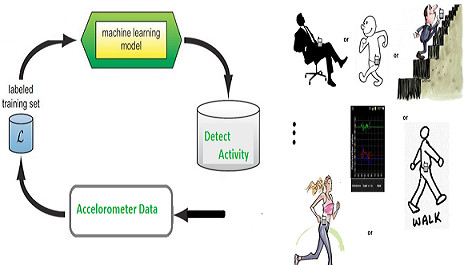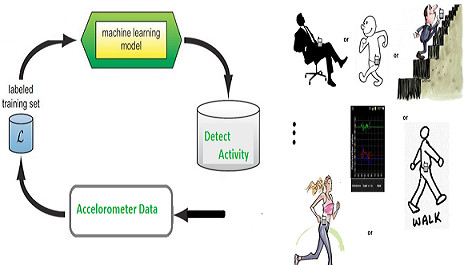

In [7]:
train_df

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819,30,WALKING_UPSTAIRS
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053,30,WALKING_UPSTAIRS
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811,30,WALKING_UPSTAIRS
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339,30,WALKING_UPSTAIRS


In [8]:
test_df=pd.read_csv("/kaggle/input/human-activity-recognition-with-smartphones/test.csv")
test_df.shape

(2947, 563)

In [9]:
test_df

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2,STANDING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,0.185361,...,-0.750809,-0.337422,0.346295,0.884904,-0.698885,-0.651732,0.274627,0.184784,24,WALKING_UPSTAIRS
2943,0.363385,-0.039214,-0.105915,-0.305388,0.028148,-0.196373,-0.373540,-0.030036,-0.270237,0.185361,...,-0.700274,-0.736701,-0.372889,-0.657421,0.322549,-0.655181,0.273578,0.182412,24,WALKING_UPSTAIRS
2944,0.349966,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,-0.347029,0.007471,...,-0.467179,-0.181560,0.088574,0.696663,0.363139,-0.655357,0.274479,0.181184,24,WALKING_UPSTAIRS
2945,0.237594,0.018467,-0.096499,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,-0.289477,0.007471,...,-0.617737,0.444558,-0.819188,0.929294,-0.008398,-0.659719,0.264782,0.187563,24,WALKING_UPSTAIRS


# Feature Engineering And EDA;

In [10]:
def show_basics(data):
    a = pd.DataFrame()
    a['Missing Value'] = train_df.isnull().sum()
    a['No. of unique Value'] = train_df.nunique()
    a['dtype'] = train_df.dtypes
    return a
show_basics(train_df)

,Missing Value,No. of unique Value,dtype
tBodyAcc-mean()-X,0,7347,float64
tBodyAcc-mean()-Y,0,7352,float64
tBodyAcc-mean()-Z,0,7349,float64
tBodyAcc-std()-X,0,7349,float64
tBodyAcc-std()-Y,0,7351,float64
...,...,...,...
"angle(X,gravityMean)",0,7352,float64
"angle(Y,gravityMean)",0,7352,float64
"angle(Z,gravityMean)",0,7352,float64
subject,0,21,int64


In [11]:
def show_basics(data):
    a = pd.DataFrame()
    a['Missing Value'] = test_df.isnull().sum()
    a['No. of unique Value'] = test_df.nunique()
    a['dtype'] = test_df.dtypes
    return a
show_basics(test_df)

,Missing Value,No. of unique Value,dtype
tBodyAcc-mean()-X,0,2947,float64
tBodyAcc-mean()-Y,0,2947,float64
tBodyAcc-mean()-Z,0,2947,float64
tBodyAcc-std()-X,0,2947,float64
tBodyAcc-std()-Y,0,2947,float64
...,...,...,...
"angle(X,gravityMean)",0,2947,float64
"angle(Y,gravityMean)",0,2947,float64
"angle(Z,gravityMean)",0,2947,float64
subject,0,9,int64


**Target Column;**

In [12]:
train_df['Activity'].unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [13]:
test_df['Activity'].unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

**Data Viusalization**

In [14]:
data = train_df
fig = px.pie(train_df, names='Activity', title = 'Pie plot of Activities')
fig.show()

In [15]:
fig = px.bar(data, x='angle(X,gravityMean)', y="Activity",color="Activity",width=1000,barmode='overlay', title = 'Angle between X-axis and Gravity_mean with respect to Activities')
fig.show()

In [16]:
fig = px.box(data, y= 'subject', x= 'Activity', color= 'Activity', width= 1000, boxmode='overlay', title = 'Boxplot of Activities with respect to Subject')
fig.show()

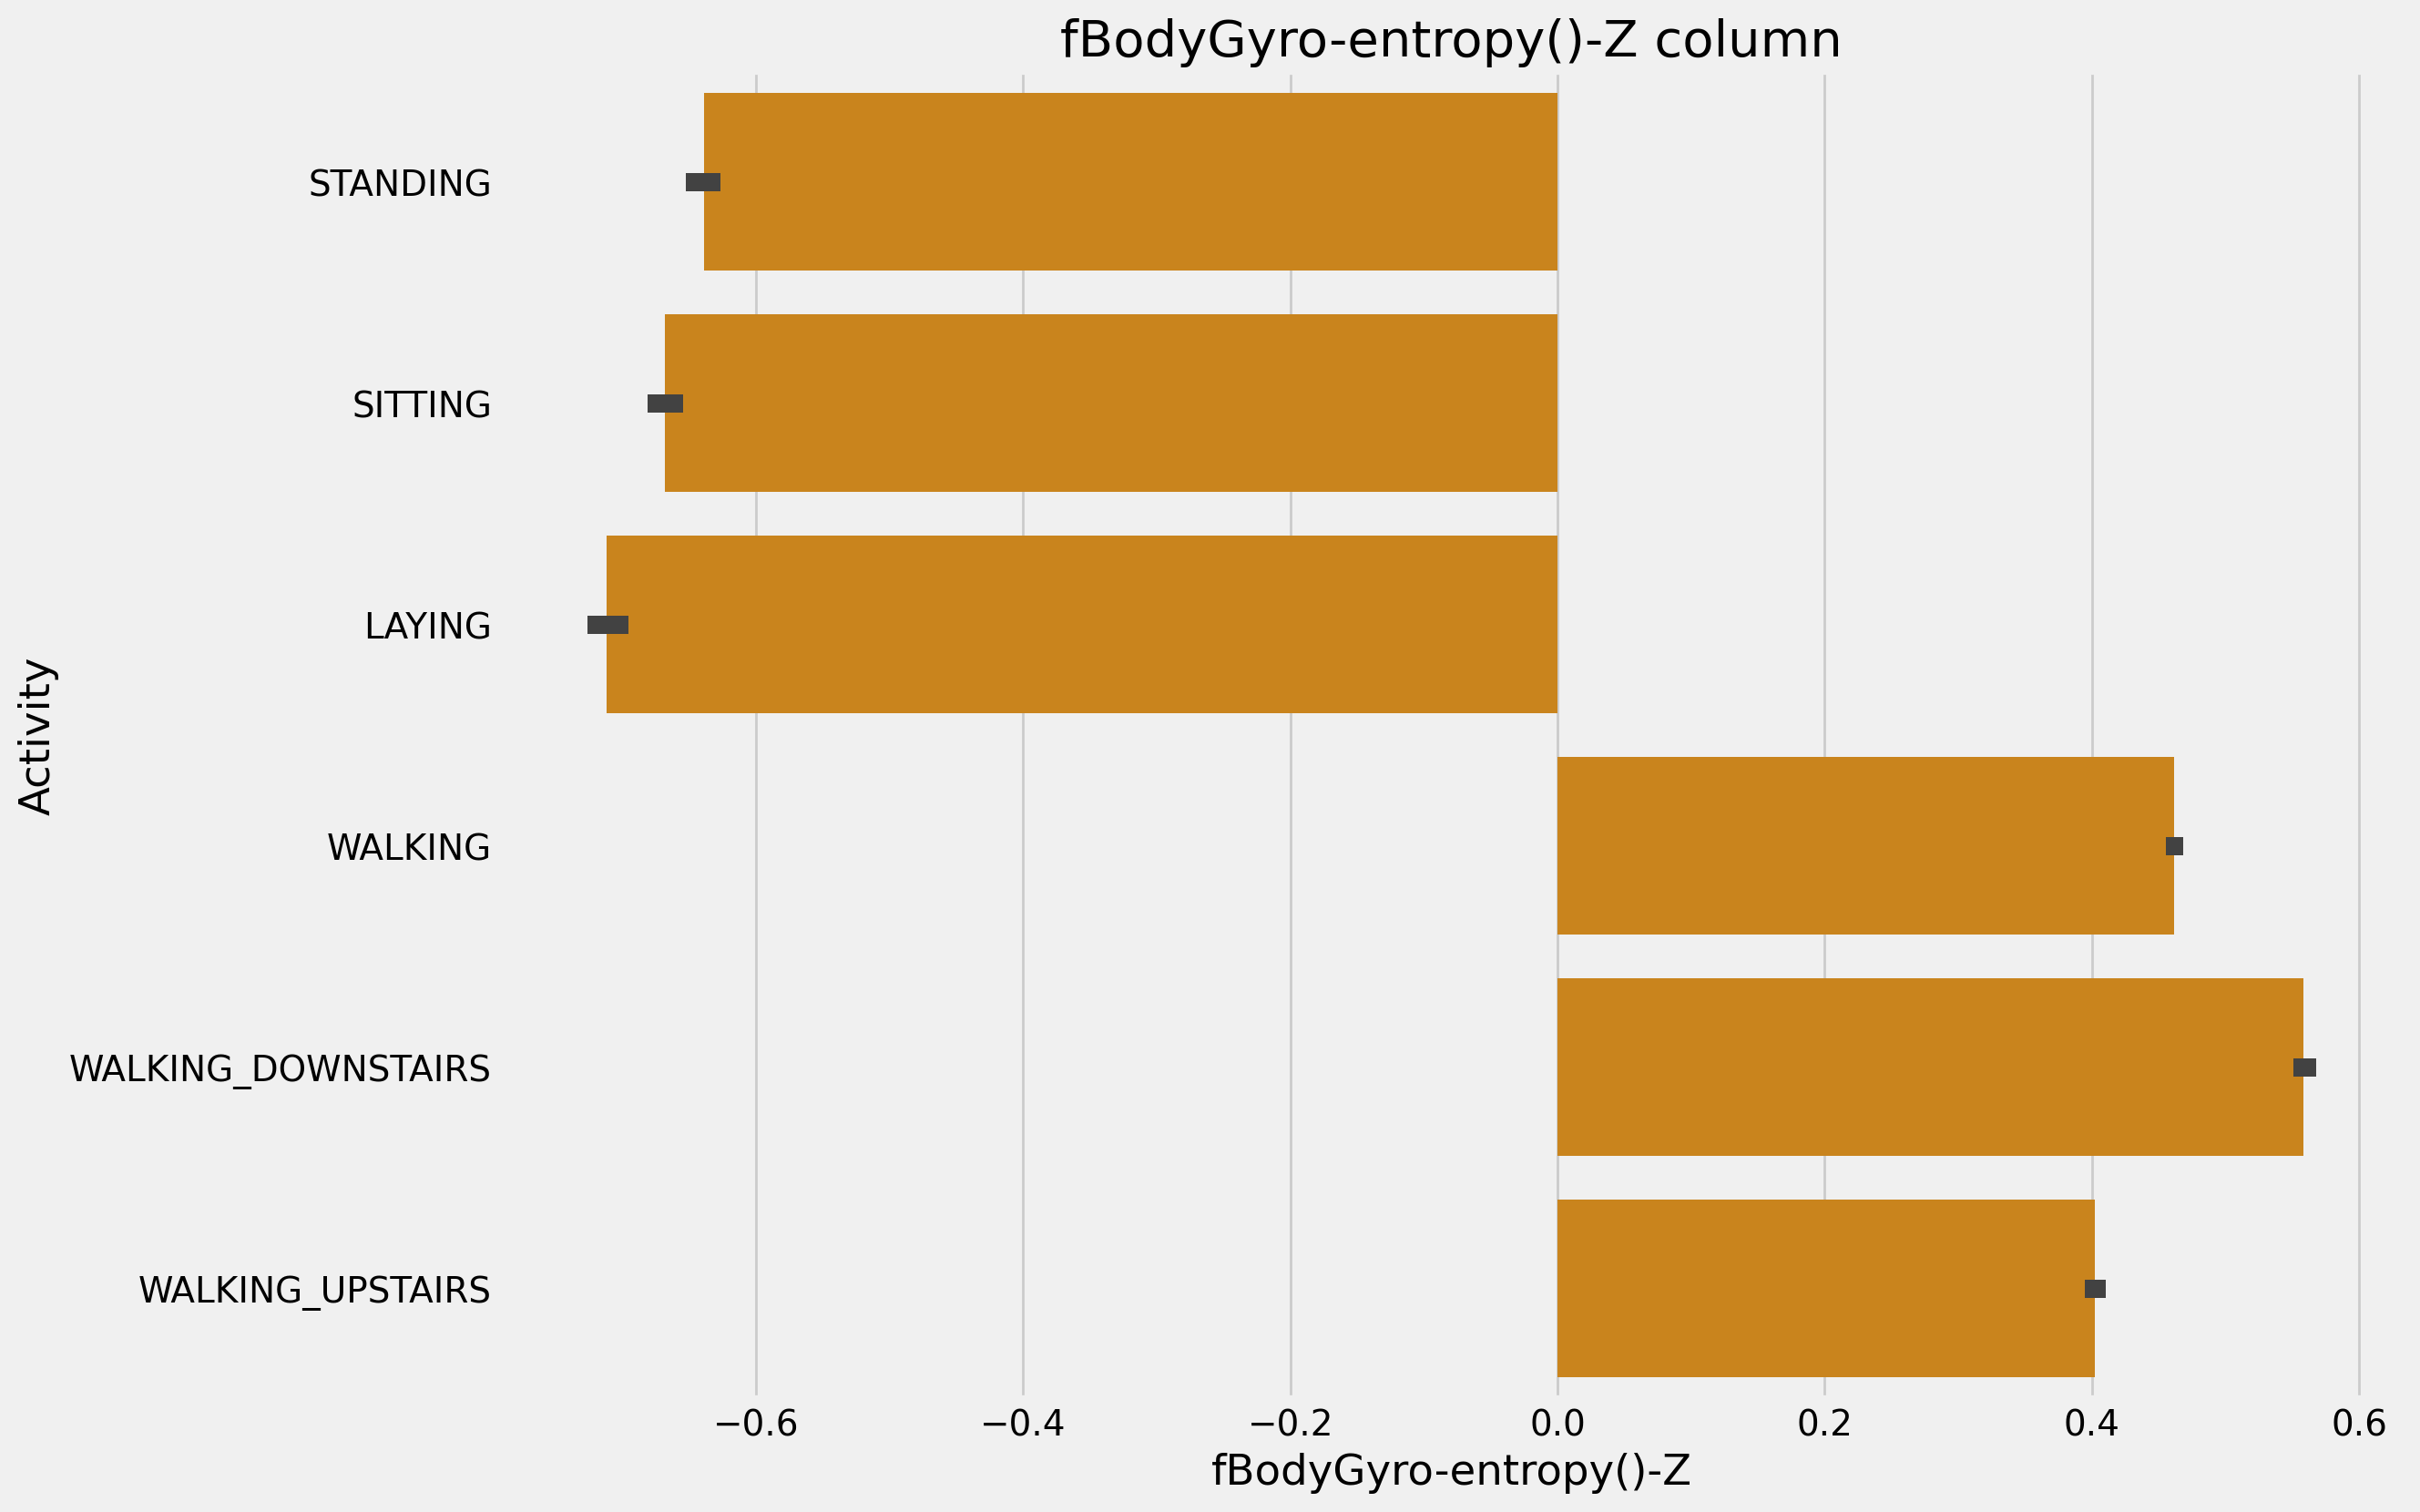

In [17]:
plt.figure(figsize=(12,9))
sns.barplot(data=data, x="fBodyGyro-entropy()-Z", y = 'Activity', color = '#e68a00')
plt.title('fBodyGyro-entropy()-Z column')
plt.show()

From the boxplot and barplot we can observe that (tGravityAcc-energy()-Y) perfectly seperates LAYING from other activities.

* If fBodyAccJerk-entropy()-X > 0 then Activity is static.
* If fBodyAccJerk-entropy()-X < 0 then Activity is dynamic



In [18]:
fig = px.box(data, y='tBodyAcc-max()-X', x="Activity",color="Activity",width=1000,boxmode="overlay")
fig.show()

# Data Pre-Processing And Split for ML model;

In [19]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.metrics import  f1_score

LebelCoding for Categorical Features

In [20]:
model_trans = LabelEncoder()

train_df['Activity'] = model_trans.fit_transform(train_df['Activity'])

test_df['Activity'] = model_trans.fit_transform(test_df['Activity'])

In [21]:
X_train=train_df.iloc[:,:-1]
y_train=train_df.iloc[:,-1]

In [22]:
X_test=test_df.iloc[:,:-1]
y_test=test_df.iloc[:,-1]

Classification Report Function define

In [23]:
def classification_task(model,features_train, y_train ,features_test ,y_test, predic,model_name):
 
    perf_df=pd.DataFrame({'Train_Score':model.score(features_train, y_train),
                          "Test_Score":model.score(features_test, y_test),
                          "Precision_Score":precision_score(y_test,predic,average = 'macro'),
                          "Recall_Score":recall_score(y_test,predic, average = 'macro'),
                          "F1_Score":f1_score(y_test,predic, average = 'macro') ,
                          "accuracy":accuracy_score(y_test,predic)}, index=[model_name])
    return perf_df

# RFC ML model Train And Evaluation;

In [24]:
# Train Random forest model on the scaled data
Random_Forest= RandomForestClassifier()
# Fit the model
Random_Forest.fit(X_train,y_train)
#predict x_test_scaled
pred_rand = Random_Forest.predict(X_test)

In [25]:
Eval_fores= classification_task(Random_Forest,X_train, y_train ,
                                X_test,y_test,pred_rand,"Random Forest" )
Eval_fores

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Random Forest,1.0,0.926705,0.927831,0.923958,0.925119,0.926705


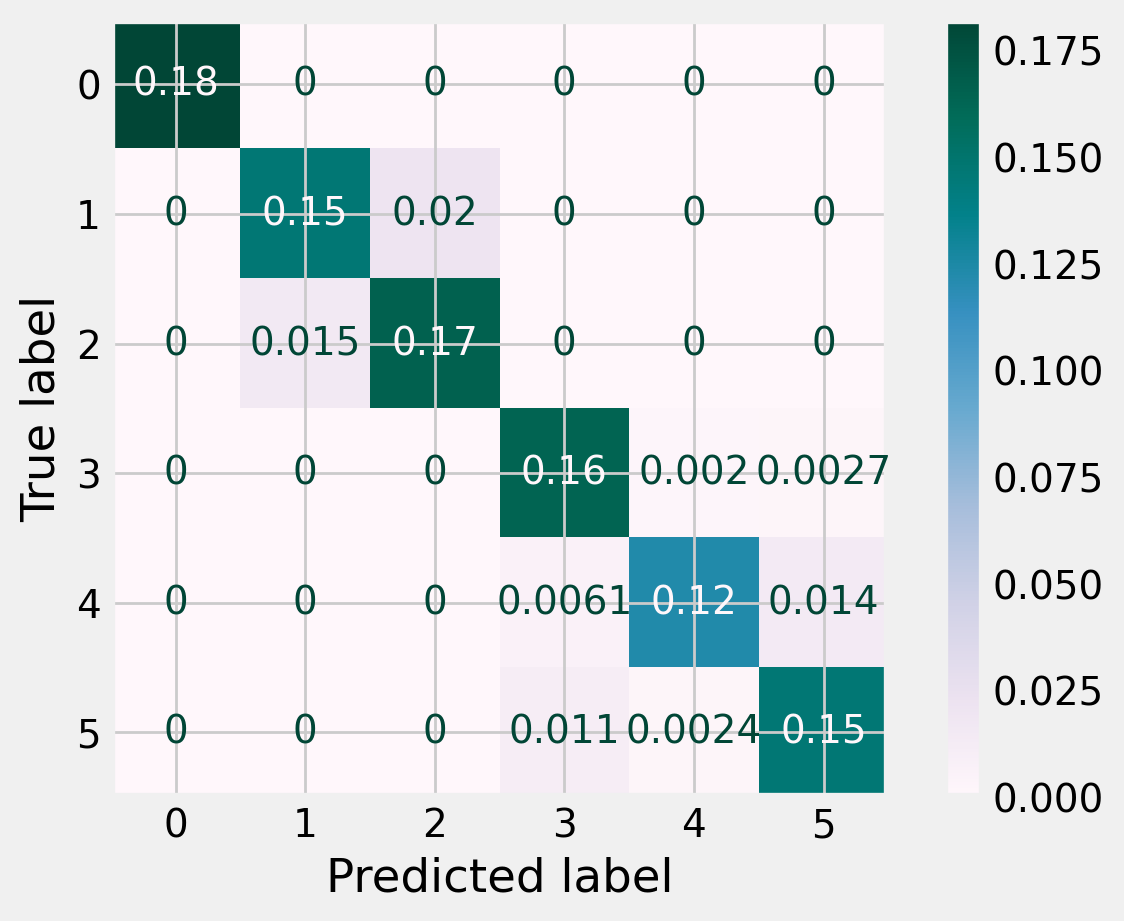

In [26]:
conf = confusion_matrix(y_test, pred_rand ,normalize="all",)
disp = ConfusionMatrixDisplay(conf).plot(cmap=plt.cm.PuBuGn)

# 1. Prototype ML Project Deployment;

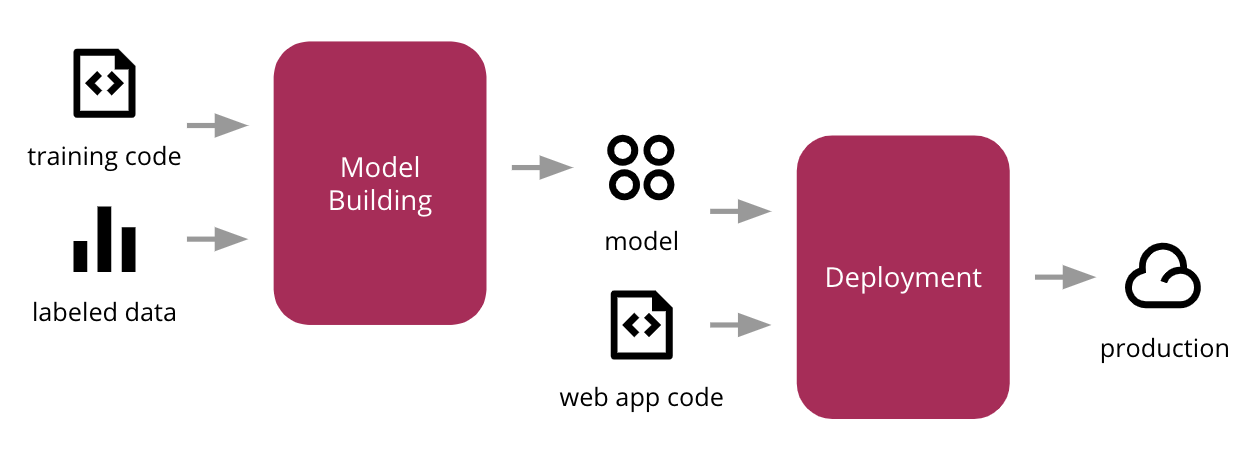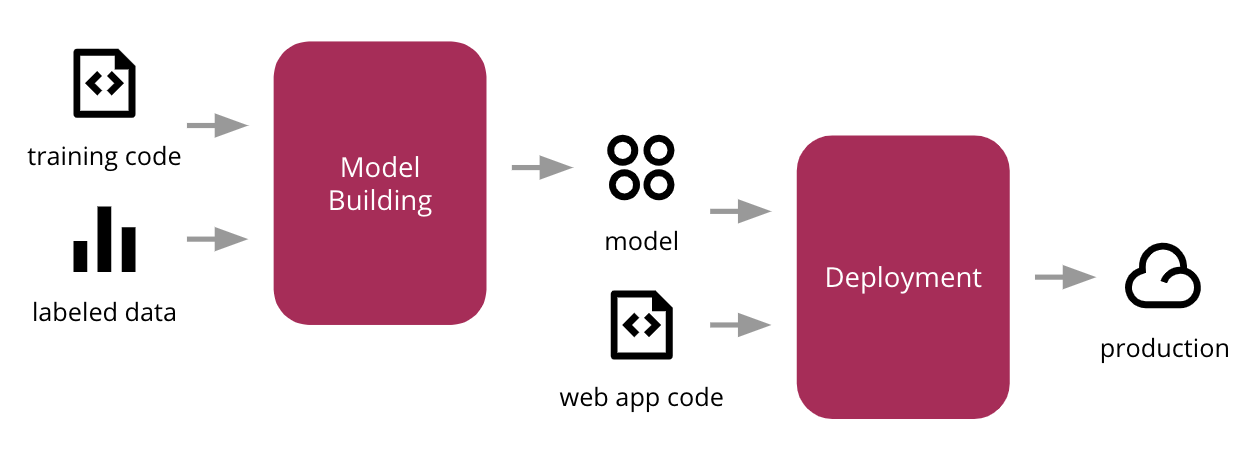

Relevant Tasks; 
* https://aws.amazon.com/blogs/machine-learning/millennium-management-secure-machine-learning-using-amazon-sagemaker/
* https://github.com/frankmollard/Stroke_Probability/blob/main/Stroke_Proba.py

In [27]:
#